# Biophysics project - Monte Carlo simulation of polymer folding

Vemund Aakre, Thorbjørn Djupvik and Oskar Feed Jakobsen

---
Chains of amino acids are the the building blocks of proteins.
These will fold themeselves in the three dimensional space and thus chemical bonding between non-neighbouring parts of the chain will occur.
The generalization of such three-dimensional structures are called *polymers*. Polymers consists of repeating units called *monomers*.
In this project we will simulate polymer folding in two dimension.
By using methods of Monte Carlo simulation we investigate physical properties of polymers.
The energy and the spacial extent of the structures are quantities that we will investigate.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from numba import njit                 # we need to explain the use of this module in our project
from scipy.constants import Boltzmann
from pathlib import Path             # probably unnecessary, but imported as "føre-var".
from typing import Callable

## The representation of a polymer
To represent a two dimensional polymer, one may try to create a two dimensional matrix to represent 2D space
and denote with for example 1 or 0 whether a monomer is located at a point in space or not. This will in general be 
unsuitable when scaling the problem, since the size of the matrix scales as $N^2$ with the size of the polymer. This also 
results in a higher computation time, because every computation done with the polymer requires iterating through the entire 
matrix. As most of the indices will be zero, this is a waste of space and time, and can be optimized.

A more efficient way of representing the polymer is just to store its monomer coordinates in a $N\times2$ matrix, reducing 
the matrix size to scale linearly with the size of the polymer. In our implementation the matrix has a size of $N\times2$, 
where each row contains the coordinate of a single monomer, $(x, y)$. The order of the rows is set to be the order
in which they appear in the polymer. For a polymer of size N, the structure would look like this:

$$
  \begin{bmatrix}
   x_1& y_1\\
   x_2& y_2\\
   \vdots&\vdots \\
   x_N& y_N\\
  \end{bmatrix}
$$

### A couple of conventions
Following the naming convention of the project description, we will name the first monomer 'monomer 1', and not by its index 
in the matrix. We will also define the head of a polymer with respect to a given monomer $i$, to be all monomers $j$
where $j<i$. The tail is defined identically for $j>i$.


## Polymers in action
To be able to work with polymers in the code, it is nice to have a function to automatically create a polymer of a given size 
without having to manually type it into the code.
The function `generate_flat_polymer` generates a flat polymer of a given length centered around the origin.

In [2]:
@njit
def generate_flat_polymer(
    polymer_length: int, mid_of_polymer: np.ndarray = np.zeros(2)
) -> np.ndarray:
    """Genererer en horisontal polymer med N monomerer

    Args:
        polymer_length (int): N antall monomerer
        mid_of_polymer (np.ndarray, optional): Midtpunktet til polymeren, Defaults to np.zeros(2).

    Returns:
        np.ndarray: den genererte polymeren
    """
    polymer_array = np.zeros((polymer_length, 2), dtype=np.int32)
    polymer_start = -int(polymer_length / 2) + mid_of_polymer[0]
    # + 1/2 for å håndtere partall
    polymer_end = int((polymer_length + 1) / 2) + mid_of_polymer[0]
    polymer_array[:, 1] = mid_of_polymer[1]
    polymer_array[:, 0] = np.arange(polymer_start, polymer_end, 1, dtype=np.int32)

    return polymer_array

It is beneficial to be able to visualize the polymers whilst working with them. This helps debugging the code and analyzing the problems at hand.
The function `illustrate_polymer` displays the polymer in a grid of size $N\times N$ with a color gradient to separate the 
monomers from each other.

In [3]:

def illustrate_polymer(
    ax,
    polymer: np.ndarray,
    cmap: str = "binary",
    numbers: bool = False,
    title: str = ""
) -> None:
    """
    Uses matplotlib.pyplot.pcolormesh to illustrate a polymer.

    Args:
        ax: Axes to plot on
        polymer: Nx2-dimensional array containing coordinates for the N monomers
        cmap: matplotlib colormap
        number: Defaults to False. If True the monomers will display their index
        title: Title
        
    Returns:
        None
    """
    # Make a NxN-grid
    N = len(polymer)
    x = y = np.arange(N + 1)
    Z = np.zeros((N, N))

    # Placing the polymer on the grid such that the middle monomer is in the center.
    middle_monomer = polymer[int(N / 2)]
    for i, monomer in enumerate(polymer):
        shifty = (1 if N % 2 == 0 and middle_monomer[1] < 0 else 0)
        shiftx = (1 if N % 2 == 0 and middle_monomer[0] < 0 else 0)
        x_coord = monomer[1] + int(N / 2) - middle_monomer[1] - shifty
        y_coord = monomer[0] + int(N / 2) - middle_monomer[0] - shiftx
        Z[x_coord, y_coord] = i + 2
        if numbers:
            ax.text(y_coord + 0.5, x_coord + 0.5, i + 1, size="x-large", color='red')

    ax.pcolormesh(x, y, Z, shading="flat", cmap=cmap)
    ax.set(title=title, xticks=x, xticklabels=[], yticks=y, yticklabels=[])
    ax.tick_params(axis="both", left=False, right=False, bottom=False, top=False)
    ax.grid(True)

Let us use `illustrate_polymer` to get a sense of how a flat polymer consisting of 10 monomers look like. The numbers $1$ through $10$ walks the polymer from it's head to it's tail.

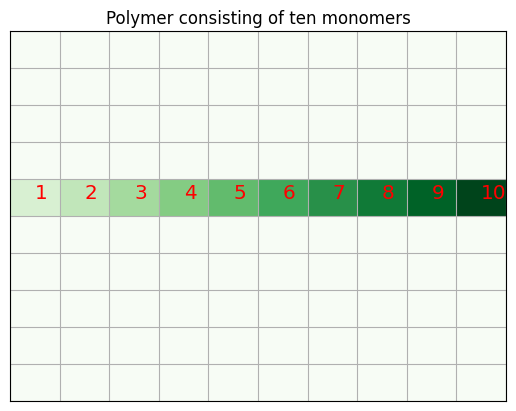

In [4]:
polymer = generate_flat_polymer(polymer_length=10)
fig, ax = plt.subplots()
illustrate_polymer(ax, polymer, numbers=True, cmap="Greens", title="Polymer consisting of ten monomers")
plt.show()

### Validation

As per the project description, our model is a simplified 2D-model of polymers, and the polymers are therefore subject to 
certain restrictions. A polymer of size $N$ is only considered *intact* if it satisfies the following rules:

1. It has $N$ monomers.
2. Each monomer is represented by a unique integer $m \in [1, N]$. This means that no monomer is represented by the same number as another monomer.
3. A monomer represented by the integer $m$ is the closest neighbour to the monomers represented by the integers $m-1$ and $m+1$. Monomers at the ends, $m=1$ and $m=N$ , need only to be closest neighbour to $m=2$ and $m=N-1$ respectivly. Two monomers are closest neighbours if the distance between them is exactly equal to one.
4. Two monomers do not occupy the same space simultaneously. 

Thus, when trying to fold a polymer, we always have to check its validity before attempting to operate on it. The functions 
defined underneath all implements the validation-logic. An important thing to note is that the validation function needs to 
be fast. When running the simulation, it might get called multiple times for every Monte-Carlo step. This means that the time 
the program spends in this function accumulates quickly to a considerable size when running the simulation functions we will 
define in a later section.
Here are three different implementations, ordered by the time of writing, where we have tried to optimize the time spent.

The first one is a for-loop implementation. It has the benefit of an early return if the polymer is not intact when checking 
the distances between neighbouring monomers. Method 2 
on the other hand will always run the worst case scenario and check all the distances before returning. However it is",
completely implemented with numpy functions, and for that reason it is actually faster as we will see in the [Benchmarks](#Benchmarks) 
section. The last implementation uses numba to 
JIT-compile the function. Because numba does not support np.unique with axis specified, we had to rewrite that part to python 
for-loops. Here we could again utilize the early return optimization, but now when checking for overlap in the polymer.

We 
will return to the details of these implementations when we discuss the time usage in the [Benchmarks](#Benchmarks) section, but for now 
it can 
be said that `check_if_intact` is the fastest of them, and the one we will use."

In [5]:
def check_if_intact_1(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): The polymer to check
        polymer_length (int): Length of the polymer

    Returns:
        bool: True if the polymer is intact
    """
    # Checks that the polymer has N monomers, where each has a unique whole number representation
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False

    for i in range(1, polymer_length):
        # Don't have to take the square root (faster), as any value different from 1 indicates a broken polymer anyway.
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2
        if distance != 1:
            return False
    return True

In [6]:
def check_if_intact_2(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): The polymer to check
        polymer_length (int): Length of the polymer

    Returns:
        bool: True if the polymer is intact
    """
    # Checks that the polymer has N monomers, where each has a unique whole number representation
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False

    test = polymer[1:]
    test_mot = polymer[:-1]
    # Don't have to take the square root or square (faster), as any value different from 1 indicates a broken polymer anyway.
    distance_array = np.abs(test[:, 0] - test_mot[:, 0]) + np.abs(
        test[:, 1] - test_mot[:, 1]
    )
    if np.any(distance_array != 1):
        return False
    return True

In [7]:
@njit
def check_if_intact(polymer: np.ndarray, polymer_length: int) -> bool:
    """Checks if polymer is intact

    Args:
        polymer (np.ndarray): polymer that is checked
        polymer_length (int): length of the polymer

    Returns:
        bool: True if polymer is intact
    """

    if len(polymer) != polymer_length:
        return False

    unique_monomer = np.zeros_like(polymer)
    # First monomer is always unique
    unique_monomer[0] = polymer[0]

    # Does not have to check the first monomer
    for i in range(1, polymer_length):
        for j in range(i):
            # checks that the monomer's coordinates are not similar to a previous monomer
            if (
                polymer[i, 0] == unique_monomer[j, 0]
                and polymer[i, 1] == unique_monomer[j, 1]
            ):
                return False
            else:
                unique_monomer[i] = polymer[i]

    test = polymer[1:]
    test_against = polymer[:-1]
    # Don't need squareroot since all other values than 1 means that it is not intact
    distance_array = (test[:, 0] - test_against[:, 0]) ** 2 + (
        test[:, 1] - test_against[:, 1]
    ) ** 2

    # If distance-array contains anything other than 1, the polymer is not intact
    if np.any(distance_array != 1):
        return False
    return True

### Rotation

To rotate a polymer around a given monomer, we only need to look at the relative position between the rotation center and the 
monomers which are to be rotated. Let's denote the coordinates of the rotation center as $(x_s, y_s)$, and of an arbitrary 
monomer as $(x_0, y_0)$. Then the relative position of the monomer with respect to the rotation center is given by
$$
    (x_{0, \text{rel}}, y_{0, \text{rel}}) = (x_0-x_s, y_0-y_s).
$$
When the monomer is rotated, the new relative coordinates in terms of the old ones is
$$
    (x_{1, \text{rel}}, y_{1, \text{rel}}) = k \cdot (- y_{0, \text{rel}}, x_{0, \text{rel}}),
$$
where $k=1$ if the rotation is in the positive direction, and $k=-1$ if it is in the negative direction.
The new coordinates of the monomer then becomes
$$
    (x_{\text{rot}}, y_{\text{rot}}) = (x_s, y_s) + k \cdot (-y_{\text{rel}}, x_{\text{rel}}) = (x_s, y_s) + k \cdot (-(y_0 - y_s), x_0 - x_s).
$$
When implementing this, one can make a small optimization by always rotating the shortest end of the polymer with respect 
to the rotation center. This reduces the number of computations and ensures that the center of the polymer does not move too 
much when rotating. In the case that the head and tail are equally long, it does not matter which one gets rotated. In our,
implementation we have defined it to just rotate the tail. In order to speed up the function, we have utilised `Numpy`,
slicing and `Numba` JIT-compiling. We will expand on this and the difference between the two versions in the [Benchmarks](#Benchmarks) section.


In [8]:
@njit
def rotate_polymer(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Rotates a polymer in the given direction around a monomer

    Args:
        polymer: A 2D numpy array with monomer coordinates

        rotation_center: Which monomer to rotate around
        `Note: It is not the index, but the monomer_number. [1, N]`

        positive_direction: Rotate in the positive direction if True, or negative direction if False

    Returns:
        a rotated copy of the polymer
    """
    # Make a slicing array to rotate the correct end of the polymer
    rotation_slice = np.full(len(polymer), False)

    # Choose to rotate the shortest tail of the polymer
    if rotation_center >= len(polymer) / 2:
        rotation_slice[rotation_center:] = True
    else:
        rotation_slice[:rotation_center] = True

    if positive_direction:
        direction = 1
    else:
        direction = -1

    # The coordinates in space of the rotation center
    rotation_position = polymer[rotation_center - 1]

    # Where _rel means the position relative to the rotation center
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_slice] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Changes the sign of the x-values

    # Makes a copy of the polymer
    new_polymer = polymer.copy()

    new_polymer[rotation_slice] = rotation_position + new_pos_rel
    return new_polymer

In [9]:
@njit
def rotate_polymer_mut(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Rotates a polymer in the given direction around a monomer

    Args:
        polymer: A 2D numpy array with monomer coordinates

        rotation_center: Which monomer to rotate around
        `Note: It is not the index, but the monomer_number. [1, N]`

        positive_direction: Rotate in the positive direction if True, or negative direction if False

    Returns:
        a rotated copy of the polymer
    """
    # Make a slicing array to rotate the correct end of the polymer
    rotation_slice = np.full(len(polymer), False)

    # Choose to rotate the shortest tail of the polymer
    if rotation_center >= len(polymer) / 2:
        rotation_slice[rotation_center:] = True
    else:
        rotation_slice[:rotation_center] = True

    if positive_direction:
        direction = 1
    else:
        direction = -1

    # The coordinates in space of the rotation center
    rotation_position = polymer[rotation_center - 1]

    # Where _rel means the position relative to the rotation center
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_slice] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Changes the sign of the x-values

    polymer[rotation_slice] = rotation_position + new_pos_rel
    return polymer

## Simulation
Up until now we have defined basic functions to operate on the polymers. Here we will define a bigger function to simulate,
multiple rotations, so we can see how the polymers behave when allowed to rotate multiple times. With this we will also be,
able to benchmark the different variants,
of the functions above to see which perform the best.

In [10]:
@njit
def simulate_rotations(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Simulates rotations of the polymer.
    ---
    Implementation of algorithm 1 in project description.

    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        valid = check_if_intact(twisted_pol, N)
        if valid:
            counter += 1
            pol = twisted_pol

    return pol, counter

Let us run `simulate_rotations` and visualize the results. First with $N = 15$ and $N_s = 4$. Thereafter with $N = 15$ and $N_s = 1000$.

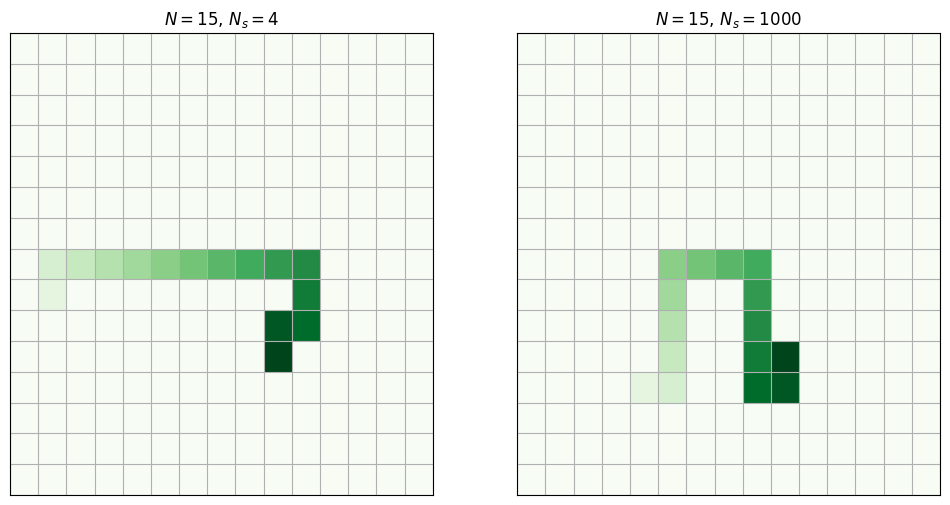

In [11]:
N = 15
polymer_1, _ = simulate_rotations(N = N, Ns = 4)
polymer_2, _ = simulate_rotations(N = N, Ns = 1000)

fig, axs = plt.subplots(1, 2, figsize=(12,6))
illustrate_polymer(axs[0], polymer_1, cmap="Greens", title="$N = 15$, $N_s = 4$")
illustrate_polymer(axs[1], polymer_2, cmap="Greens", title="$N = 15$, $N_s = 1000$")

plt.show()

### Benchmarks
For the simulation algorithms to run fast, the primary functions rotate_polymer and check_if_intact needs to be implemented in an efficient manner. During our development 
of these functions we have made several versions with different implementations. Here we benchmark the different versions to see which ones are the fastest.

In [12]:
# Can not be JIT-compiled by numba because the check_if_intact functions we test
# here are not supported by Numba
def benchmark_check_if_intact_func(
    N: int, Ns: int, check_if_intact_func: Callable[[np.ndarray, int], bool]
) -> tuple[np.ndarray, int]:
    """Simulates rotations to benchmark check_if_intact functions
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.
        check_if_intact_func: Function to check whether a polymer is intact

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        valid = check_if_intact_func(twisted_pol, N)
        if valid:
            counter += 1
            pol = twisted_pol

    return pol, counter

In [13]:
@njit
def benchmark_rotate_mut_func(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Simulates rotations to benchmark the rotate_polymer_mut function
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for _ in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        rotate_polymer_mut(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(pol, N):
            counter += 1
        else:
            # Rotates the polymer back if it is invalid
            rotate_polymer_mut(pol, rnd_monomer, not rnd_rotate)

    return pol, counter

#### Check_if_intact benchmarks

In [14]:
N = 35
Ns = 1000

print("Simulate_rotations:")
%timeit simulate_rotations(N, Ns)

print()
print("Check_if_intact_1:")
%timeit benchmark_check_if_intact_func(N, Ns, check_if_intact_1)

print()
print("Check_if_intact_2:")
%timeit benchmark_check_if_intact_func(N, Ns, check_if_intact_2)

Simulate_rotations:
3.45 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Check_if_intact_1:
115 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Check_if_intact_2:
177 ms ± 53.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here we can see that the `check_if_intact` function is indeed the fastest one. The reason is largely due to `Numba` and the JIT-compiler. When using the `@njit` 
decorator, we let `Numba` compile the
function to native machine code which gives a massive performance benefit over regular python code. [See the documentation](https://numba.readthedocs.io/en/stable/user/overview.html).
The other two results are expected, but still interesting. Although `check_if_intact_1`
technically has the theoretical best time complexity due to the early return implementation, it still gets beaten by `check_if_intact_2`. The reason being that 
`check_if_intact_2` utilizes `Numpy`
functionality, which to a large extent is written in C. The early return optimization is nice, but it is not enough to beat the heavily optimized `Numpy` operations. The 
penalty of going through the
entire matrix is simply not big enough to matter with polymer sizes capped at 35. Another point to mention is why we do not use `Numba` for the `check_if_intact_i` 
functions. This is because the full
version of the np.unique() function is not supported by `Numba`, which both functions use.

From the above there indication towards that the JIT-compiled version runs the fastest for our problem. This is however not necessarily the case for bigger polymers. To 
see how well the algorithms
scale with $N$, we have to

divide the functions into to parts. One for the part that checks for overlap of the polymer, call it part one, and one part to check whether all consecutive monomers are 
closest neighbours, call it
part two.

Let us start with,
`check_if_intact`. In part one we effectively loop over two copies of the polymer in a double loop. The time complexity for this part then scales with $N^2$.,
In part two we sum $N-1$ elements with $N-1$ other elements twice, take the absolute value, and sum the two results. Lastly we check for elements different from one. All 
these chained operations are
linear with respect to $N$, and the total is therefore linear. The entire function then scales as $N^2$ because of part one.

Now we look at `check_if_intact_1`. Part one uses np.unique which has a time complexity of $O(N\log N)$ as it uses lexiographical sorting to check for uniqeness.
[See the documentation](https://github.com/numpy/numpy). The size lookup is done in constant
time, so the entire part
scales as $n\log n$. Part two does the same operations as in `check_if_intact`, just implemented in `Python`, and scales as $N$. The early return optimization 
effectively multiplies the average time
with a constant, so the total still scales as $N$. The entire function then scales as $N\log N$ which is actually faster
than `check_if_intact`.

Lastly we look at `check_if_intact_2`. Part one is identical to `check_if_intact_1` and part two is identical to `check_if_intact`, and so the entire function scales as 
$N\log N$.

From this we actually see that `check_if_intact` scales the worst with $N$. This can however be fixed with a change in part one. If we were to implement a sorting 
algorithm as in np.unique we would
have reduced the time complexity to $N\log N$ which is the same as the others. One might also be able to hash the rows of the matrix into a hash-set, which has constant 
lookup and addition of new
element. When searching for overlap, the inner loop could then be replaced by a simple lookup, resulting in a linear complexity. The entire function would then scale 
linearly with $N$.,
When operating with polymer sizes big enough for these optimizations, there is one more thing to do. It is to completely remove the check of whether the polymer has been 
broken. They way the
rotate_polymer is implemented, it preserves the connections between consecutive monomers, and will not break the polymer. What needs to checked is just whether an overlap 
has happened.

#### Rotate_polymer_mut benchmarks

In [15]:
N = 35
Ns = 1000

print("simulate_rotations")
%timeit simulate_rotations(N, Ns)

print()
print("Rotate_polymer_mut:")
%timeit benchmark_rotate_mut_func(N, Ns)

simulate_rotations
3.73 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Rotate_polymer_mut:
8.45 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Valid rotations

As already discussed the not all rotations are considered valid.
Plot of percentage of valid rotations as function of $N$:

In [16]:
# Defining constants
N_lower = 5
N_upper = 100
N = np.arange(N_lower, N_upper)
N_s = (10, 50, 500, 1_000)

# preparing array
percentages = np.zeros((len(N_s), len(N)))

# run the simulation
for i, _N_s in enumerate(N_s):
    for j, _N in enumerate(N):
        _, valid = simulate_rotations(N=_N, Ns=_N_s)
        percentages[i, j] = (valid - 1)/_N_s   # subtract 1 because the initial state is always valid

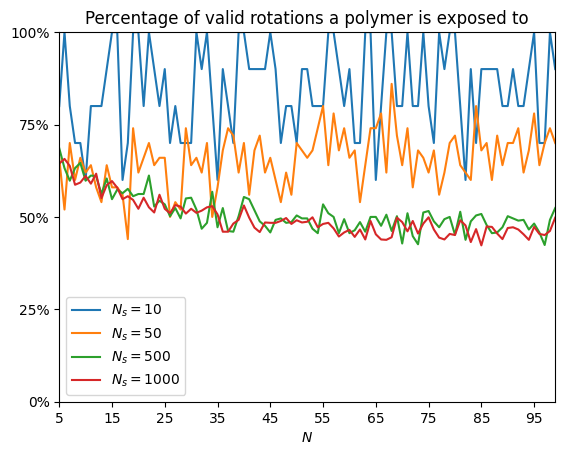

In [17]:
# plot the results for the cell above
fig, ax = plt.subplots()

for i, _percentages in enumerate(percentages):
    ax.plot(N, _percentages, label=f"$N_s = {N_s[i]}$")

ax.set(
    xlabel="$N$",
    ylabel="",
    xlim=(5,N[-1]),
    ylim=(0, 1),
    xticks=np.arange(N_lower,N_upper,10),
    yticks=np.arange(0,1.1,0.25),
    title="Percentage of valid rotations a polymer is exposed to"
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.legend()
plt.show()

### Energy
The energy of the polymer is defined as follows:

$$
    E = \frac{1}{2} \sum_{m, n} V_{mn} b_{mn}
$$

**sjå prosjektbeskrivelse for forklaring. Kor mykje treng vi å inkludere her for at teksten skal ha god samanheng og flyt?**

The $N\times N$-matrix $V$ is a constant while the quantity $b_{mn}$ has to be calculated for each step:

\begin{equation}
 b_{mn} =
  \begin{cases}
  1 & m \text{ and } n \text{ closest neighbours} \\
  0 & \text{otherwise} 
  \end{cases}
\end{equation}

A function to generate the $V$-matrix proves to be useful.

In [18]:
def gen_V_matrix(
    size: int, fill_value: float | tuple[float, float] = -1.0
) -> np.ndarray:
    """
    With fill_value = -1 gen_V_matrix generates a size*size matrix:
         0  0 -1 -1 ... -1 -1 -1
         0  0  0 -1 ... -1 -1 -1
        -1  0  0  0 ... -1 -1 -1
        .          .           .
        .            .         .
        .              .       .
        -1 -1 -1 -1 ...  0  0  0
        -1 -1 -1 -1 ... -1  0  0

    Args:
        size: size of array
        fill_value: float | tuple[lower, upper]

    Returns:
        the matrix
    """
    if type(fill_value) == float:
        V = np.full((size, size), fill_value)

    else:
        assert len(fill_value) == 2, "There is an error in the type of fill_value"
        rng = np.random.default_rng()
        V = np.zeros((size, size))
        for i in range(1, size):
            for j in range(i):
                value = rng.uniform(fill_value[0], fill_value[1])
                V[i, j] = value
                V[j, i] = value

    np.fill_diagonal(V, 0)
    np.fill_diagonal(V[:-1, 1:], 0)
    np.fill_diagonal(V[1:, :-1], 0)
    # this can be done in the for-loops, but this is easier to read and is more foolproof

    return V

In order to find $b$ we would have to know which of the monomers are closest neighbours.

We wrote two implementations that both have their pros and cons:

- `calculate_energy`:
    - neg: brukar `for`-løkker. pos: utnyttar symmetrien til $V$ og $b$.
- `calculate_energy_2`
    - neg: brukar meir minne. pos: brukar utelukkande `numpy` og er dermed ein smule raskare
 
**visa til benchmarks og testing av hastigheit og minnebruk?** 

In [19]:
# Funksjonen kan, (og bør?), JIT-kompileres av numba
@njit()
def calculate_energy(polymer: np.ndarray, V: np.ndarray) -> np.float32:
    """Regner ut energien til et gitt polymer.

    Args:
        polymer: et numpy-array med monomer-koordinatene til et gyldig polymer

        V: matrise med styrken på vekselvirkninger mellom monomerene.
        V[i, j] = V[j, i] = styrken mellom monomer nummer (i+1) og (j+1)

    Returns:
        Energien til hele polymeret
    """
    N = len(polymer)
    # En matrise som angir om monomer (i+1) og (j+1) er naboer. b_matrix[i, j] = 1 dersom de er naboer.
    b_matrix = np.zeros((N, N))
    for i in range(0, N):
        # Trenger kun å se på monomer-sammensetninger som ikke har blitt sjekket enda.
        # Nabomonomeren er alltid en nabo uten vekselvirkning, så trenger ikke sjekke den.
        for j in range(i + 2, N):
            # Kun nærmeste-nabo koordinater gir en euklidsk avstand på nøyaktig 1.
            if np.sum((polymer[i] - polymer[j]) ** 2) == 1:
                # Trenger bare fylle den nedre trekanten av matrisen,
                # siden den ellers ville vært symmetrisk. (Merk j>i)
                b_matrix[j, i] = 1
    # Trenger ikke dele på 2 siden vi bare fyller ut den nedre trekanten av b_matrix;
    # vi dobbelteller ikke.
    return np.sum(V * b_matrix)

In [20]:
@njit
def calculate_energy_2(polymer: np.ndarray, V: np.ndarray) -> float:
    """idk... think it works. maybe. see Oskar's notebook for details lol."""
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2*N,N)
    b = np.where(np.abs(L[::2] - L[::2].transpose()) + np.abs(L[1::2] - L[1::2].transpose()) == 1, 1, 0)
    return 0.5*(np.sum(V*b))

#### calculate_energy benchmarks

`calculate_energy` and `calculate_engergy_2` solves the same problem using two different approaches and gets across some interesting points relating to numerical programming in python.

In `calculate_energy` we approach the problem of finding the $b$-matrix by trying to minimize the number of floating point operations. This is done by utilizing the symmetric nature of the problem: if monomers $m$ and $n$ are closest neighbours, then monomers $n$ and $m$ are closest neoghbours. The consequence is that we only check the relations once and thus we do not divide by $2$ at the end. In addition it is reduntant to check if monomers $m$ and $m+1$/$m-1$ are closest neighbours since $V_{m,m\pm1}$ is set to $0$ such that the product $V_{m,m\pm1}b_{m,m\pm1}$ will result in $0$ regardless of the value of $b_{m,m\pm1}$.

`calculate_energy_2` utilizes the power of Numpy, but do not try to minimize memory usage nor the number of floating point operations. Exploiting the function `numpy.where` and numpy slicing we managed to solve the problem without using python `for`-loops.

In [21]:
N = 35
Ns = 1000
V = gen_V_matrix(N)
polymer, _ = simulate_rotations(N, Ns)


print("\ncalculate_energy")
%timeit calculate_energy(polymer, V)

V = gen_V_matrix(N)
polymer, _ = simulate_rotations(N, Ns)

print("\ncalculate_energy_2")
%timeit calculate_energy_2(polymer, V)

V = gen_V_matrix(N)
polymer, _ = simulate_rotations(N, Ns)

print("\ncalculate_energy")
%timeit calculate_energy(polymer, V)

V = gen_V_matrix(N)
polymer, _ = simulate_rotations(N, Ns)

print("\ncalculate_energy_2")
%timeit calculate_energy_2(polymer, V)

# TODO: why do we get different results whether we run it after restarting the kernel versus running it multiple times in a row?


calculate_energy
67.7 µs ± 5.94 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

calculate_energy_2
25.4 µs ± 7.47 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

calculate_energy
66.4 µs ± 557 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

calculate_energy_2
13.9 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


**TODO: discuss the results from the cell above**

**TODO** 1j)

Now that the basic functionality has been implemented and tested for speed it is time to run some larger simulations!

---

## Larger simulations and investigations of physical quantities

**nødvendig med veldig utførleg forklaring her?**

In [22]:
def metropolis(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray]:
    """Kjører metropolis-algoritmen som beskrevet i oppgaveheftet

    Args:
        pol: polymer starttilstand
        N_s: Antall forsøk på rotasjon
        V: Vekselvirkningene mellom to gitte monomerer
        T: temperaturen i kelvin

    Returns:
        (Siste polymer , array med alle energiene som ble simulert)
    """
    E_array = np.zeros(N_s)
    N = len(pol)
    E = calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            i += 1
            E_new = calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new
            # TODO: Bruke en annen distribusjon enn uniform?
            # TODO: Boltzmann-konstanten er liten. Sjekk at python håndterer det.
            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            E_array[i] = E

    return pol, E_array

Let us run two simulations of `metropolis`.

We fixate $N = 30$, $N_s = 5000$ and  

**TODO: dette va schtøgt, skal vi ha det med?**
$$V =
  \begin{bmatrix}
   0& 0 & & &  &  −4.0&  \cdot& 10^{−21} &\text{J}\\
   0& 0 & 0 & &  &  &  &  & \\
   & 0 & 0 & 0 &  &  &  &  & \\
   &  & 0 & 0 &  &  &  &  & \\
   &  &  &  &  \ddots&  & &  & \\
   &  &  &  &  &  0&  0&  & \\
   &  &  &  &  &  0&  0&  0& \\
   −4.0&  \cdot& 10^{−21} &\text{J}  &  &  &  0&  0& 0\\
   &  &  &  &  &  &  &  0& 0\\
  \end{bmatrix}$$

In order to look at how the temperature affects the polymer we use the following values:

\begin{align}
T_\text{low} &= 70 \text{K} \\
T_\text{high} &= 350 \text{K}
\end{align}

In [23]:
# Define constants
N = 30
Ns = 5000
V = gen_V_matrix(size=N, fill_value=-4e-21)
T_low = 70
T_high = 350

# run the simulation
polymer_low, E_low = metropolis(generate_flat_polymer(N), N_s=Ns, V=V, T=T_low)
polymer_high, E_high = metropolis(generate_flat_polymer(N), N_s=Ns, V=V, T=T_high)

Plotting the energy $E$ as function of iteration step $t$ for the two temperatures.

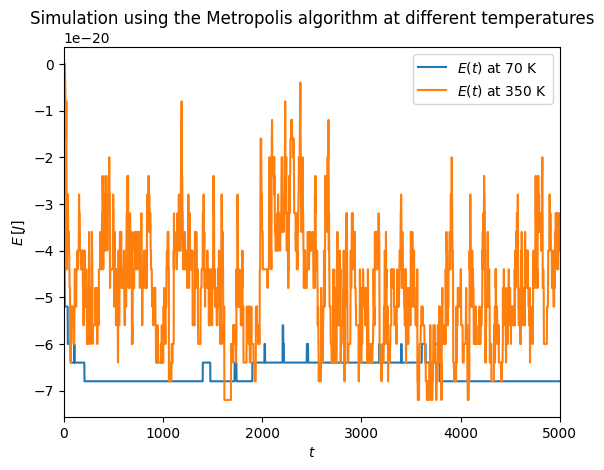

In [24]:
# Plot the results
fig, ax = plt.subplots()

ax.plot(E_low, label=f"$E(t)$ at ${T_low}$ K")
ax.plot(E_high, label=f"$E(t)$ at ${T_high}$ K")

ax.legend()
ax.set(
    title="Simulation using the Metropolis algorithm at different temperatures",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
plt.show()


It is clear from the plot that increasing the temperature results in the polymer occupying more energy states.
Therefore it has a higher probability of exploring the states that has the lowest energy.
Due to the high temperature the polymer is more ``wiggly'' and thus has a lower probability of getting stuck in a local minima.
The polymer at the lower temperature struggles to get out of such wells and thus the graph of the energy function is flatter.

**TODO maybe: illustration?**

Looking at the final positions of the polymers provide insight into the ...

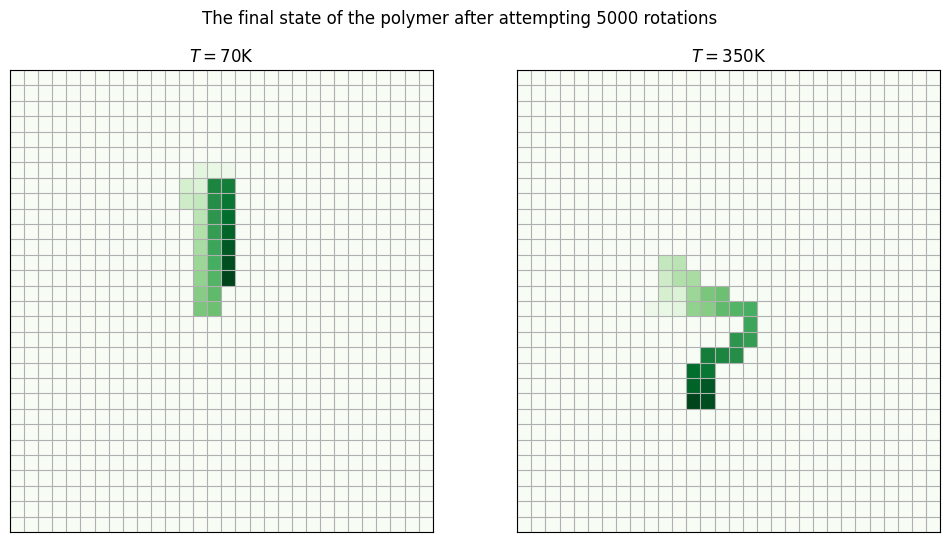

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
illustrate_polymer(axs[0], polymer_low, cmap="Greens", title=f"$T = {T_low} $K")
illustrate_polymer(axs[1], polymer_high, cmap="Greens", title=f"$T = {T_high} $K")
fig.suptitle(f"The final state of the polymer after attempting {Ns} rotations")
plt.show()

It is difficult to extract useful information from looking at a single iteration of a stochastic simulation.
The rotations (and thus the energy levels) are subject to randomness.
However, analyzing the distribution of the energies ($E(t)$) provides insights about the system.

Looking at the final positions of the polymers above we see that...

Even though this was the result at the time of writing, the next run will produce a different result.

### Understanding the $V$-matrix

The $V$-matrix holds information about how monomers interact.
Let us experiment a bit with the setup of this matrix.

- **Setup 1**\
  Using positive entries in the matrix\
  Expected outcome: flat polymers (repulsion).

- **Setup 2**\
    Scale all entries by a factor of $100$. Set the signs of entries at the upper right and lower left corners to be negative and all other entries to be positive.\
    Expected outcome: forming a ring? If $N_s$ is high enough the ends will stick together once they touch.

- **Setup 3**\
    Scaling a single entry by a factor of $100$ (ensuring that the matrix still is symmetric.)\
    Expected outcome: 
    
In order to look at these cases we will run `metropolis` on a polymer of size $x$ a few times at temperature $T = 150$ K and visualize the resulting polymers.

In [26]:
# Defining constants
N = 30
Ns = 5000
scaling = 100
T = 150
fill_value = -4e-21
pol = generate_flat_polymer(N)

# Creating the matrices
# setup 1
V1 = gen_V_matrix(size=N, fill_value=-fill_value)

# setup 2
V2 = gen_V_matrix(size=N, fill_value=fill_value*scaling)
for i in range(2, N-2):
    np.fill_diagonal(V2[:-i, i:], -fill_value*scaling)
    np.fill_diagonal(V2[i:, :-i], -fill_value*scaling)

# setup 3
V3 = gen_V_matrix(size=N, fill_value=fill_value)
V3[2, int(N/2)] *= scaling
V3[int(N/2), 2] *= scaling


# running the simulation
pol1, E_array1 = metropolis(pol=pol, N_s=Ns, V=V1, T=T)
pol2, E_array2 = metropolis(pol=pol, N_s=Ns, V=V2, T=T)
pol3, E_array3 = metropolis(pol=pol, N_s=Ns, V=V3, T=T)

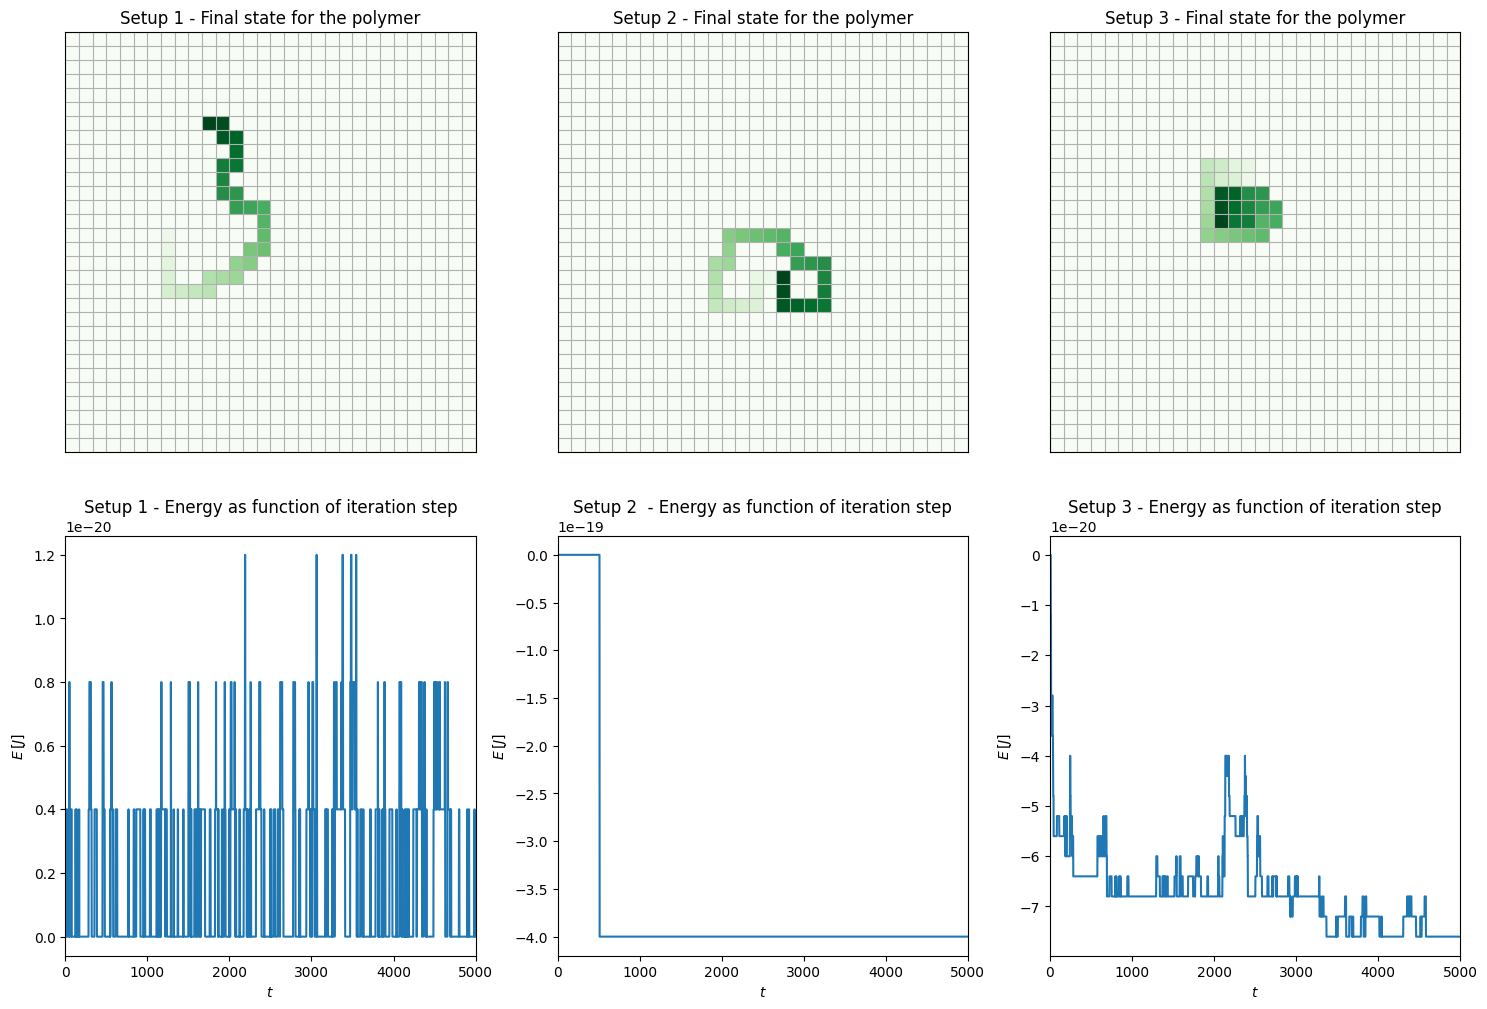

In [27]:
# plot and visualization for the cell above
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[1, 0].plot(
    E_array1
)
axs[1, 1].plot(
    E_array2
)
axs[1, 2].plot(
    E_array3
)
axs[1, 0].set(
    title="Setup 1 - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
axs[1, 1].set(
    title="Setup 2  - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)
axs[1, 2].set(
    title="Setup 3 - Energy as function of iteration step",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0,Ns)
)

illustrate_polymer(axs[0, 0], pol1, cmap="Greens", title="Setup 1 - Final state for the polymer")
illustrate_polymer(axs[0, 1], pol2, cmap="Greens", title="Setup 2 - Final state for the polymer")
illustrate_polymer(axs[0, 2], pol3, cmap="Greens", title="Setup 3 - Final state for the polymer")

plt.show()

Two effects is clear from these results:

1. Scaling the entries in the $V$-matrix results in the polymer finding a low-energy state and staying there (at least at $T = 150$ K).
2. The entries comtrols the interactions between the monomers. In setup $2$ we were able to create a polymer that forms a ring.
3. **TODO** more discussion

### Energy and it's dependance on temperatue

By running `metropolis` over a range of temperatures we can calculate $<E>(T)$ and $\sigma_E(T)$.

We exclude the first $1000$ steps of each simulation due to ``warm up''.

**TODO: vary $N_s$ and discuss stuffidistuff**

In [28]:
# Defining constants
T_interval = np.arange(10, 1000, 30)
N = 30
Ns = 5000
V = gen_V_matrix(N, fill_value=-4e-21)

# Preparing arrays
E_mean = np.zeros(len(T_interval))
E_std = np.zeros(len(T_interval))

# running metropolis for all T's in T_interval and calculating the mean and standard deviation.
for i, T in enumerate(T_interval):
    pol = generate_flat_polymer(N)
    pol, E_array = metropolis(pol=pol, N_s=Ns, V=V, T=T)
    E_mean[i] = np.mean(E_array[1000:])
    E_std[i] = np.std(E_array[1000:])

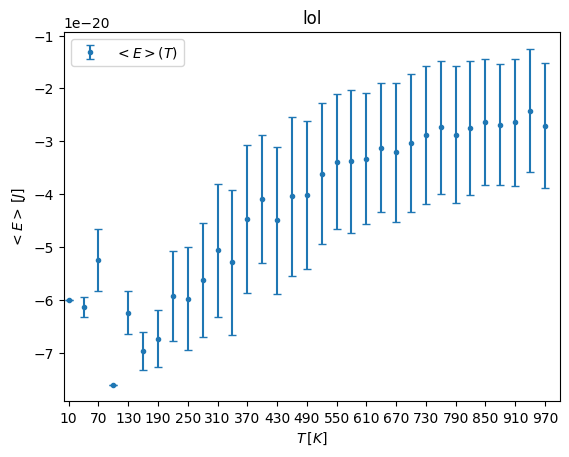

In [29]:
# just plots the results from the cell above
fig, ax = plt.subplots()
ax.errorbar(
    T_interval,
    E_mean,
    yerr=E_std,
    fmt=".",
    capsize=3,
    label=r"$<E>(T)$"
)
ax.set(
    title="lol",
    xlabel="$T\,[K]$",
    ylabel="$<E>\, [J]$",
    xticks=T_interval[::2],
    xlim=(0, 1000)
)
ax.legend()
plt.show()

Diskuter plottet og drøft temperaturavhengigheten til $⟨E⟩$ og $\sigma_E$. Hvordan påvirker valget deres av $N_s$ temperaturavhengigheten til $⟨E⟩$?

 #### Energy at lower temperatures

 
 Let us take a closer look at $T = 70 \text{K}$ by running $10$ simulations at this temperature and plotting $E(t)$.


In [30]:
# Defining constants
T = 70
num_simulations = 10

N = 30    # same as 2e)
Ns = 5000 # same as 2e)
V = gen_V_matrix(N, fill_value=-4e-21)

# Preparing array
E_array_array = np.zeros((num_simulations, Ns))

for i in range(num_simulations):
    pol = generate_flat_polymer(N)
    pol, E_array = metropolis(pol=pol, N_s=Ns, V=V, T=T)
    E_array_array[i] = E_array

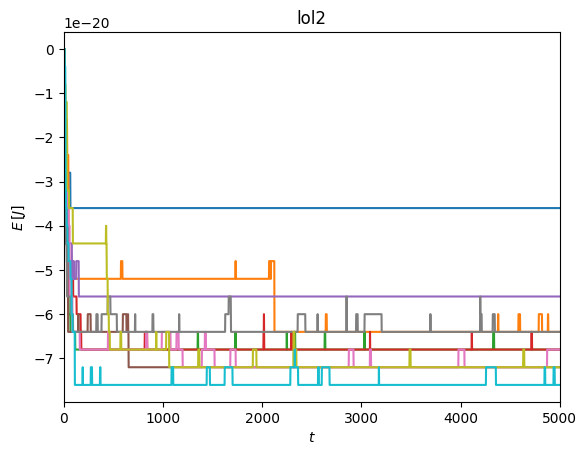

In [31]:
# just plotting the results from the cell above
fig, ax = plt.subplots()
for E_arr in E_array_array:
    ax.plot(E_arr)

ax.set(
    title="lol2",
    xlabel="$t$",
    ylabel="$E\,[J]$",
    xlim=(0, 5000)
)
plt.show()

Plott $E(t)$ fra hver simulering i en figur og forklar det dere ser.
Hvordan og hvorfor kan dette brukes til å bedre anslå energien til en polymer med lavere temperatur?

### How about the polymers spacial extent?

This is the function for calculating the diameter of a polymer

In [32]:
@njit  # TODO: Diameter kan kanskje regnes ut samtidig som energien, siden de deler store deler av koden
def calculate_diameter(polymer: np.ndarray) -> float:
    """Finds the diameter of a polymer

    Args:
        polymer (np.ndarray): the polymer to find the diameter of

    Returns:
        float: diameter of the polymer
    """
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2 * N, N)
    return np.sqrt(
        np.max(
            (L[::2] - L[::2].transpose()) ** 2 + (L[1::2] - L[1::2].transpose()) ** 2 # This makes a matrix with all the distances between monomers
        )
    )


The metropolis algorithm with a diameter calculation included

In [59]:
@njit
def metropolis_diameter(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Kjører metropolis-algoritmen som beskrevet i oppgaveheftet

    Args:
        pol: polymer starttilstand
        N_s: Antall forsøk på rotasjon
        V: Vekselvirkningene mellom to gitte monomerer
        T: temperaturen i kelvin

    Returns:
        (Siste polymer , array med alle energiene som ble simulert, array with all diameters)
    """
    # E_array = np.zeros(N_s)
    Dia_array = np.zeros(N_s)
    N = len(pol)
    E = calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            i += 1
            E_new = calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new
            # TODO: Bruke en annen distribusjon enn uniform?
            # TODO: Boltzmann-konstanten er liten. Sjekk at python håndterer det.
            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            # E_array[i] = E
            Dia_array[i] = calculate_diameter(pol)


    return pol, E_array, Dia_array

Simulating rotation and diameter for different temperatures.
The last simulation goes through the temperature array from high to low, and uses the resulting polymer from the previous simulation on the next simulation.
This simulates cooling down a polymer.

In [83]:

# Defining constants
T_interval = np.arange(10, 1000, 30)
N = 30
Ns = 5000
V = gen_V_matrix(N, fill_value=(-6*10**(-21), -2*10**(-21))) 

# Preparing arrays
# E_mean = np.zeros(len(T_interval))
# E_std = np.zeros(len(T_interval))



# running metropolis for all T's in T_interval and calculating the mean and standard deviation.
d_mean = np.zeros(len(T_interval))
d_std = np.zeros(len(T_interval))

d_rep_mean = np.zeros(len(T_interval))
d_rep_std = np.zeros(len(T_interval))

T_rep_interval = np.flip(T_interval)
for i, T in enumerate(T_interval):
        pol = generate_flat_polymer(N)
        pol, E_array, d_array = metropolis_diameter(pol=pol, N_s=Ns, V=V, T=T)

        # E_mean[i] = np.mean(E_array[1000:])
        # E_std[i] = np.std(E_array[1000:])
        d_mean[i] = np.mean(d_array[1000:])
        d_std[i] = np.std(d_array[1000:])

pol_rep = generate_flat_polymer(N)
for i, T in enumerate(T_rep_interval):
        pol_rep, E_array, d_array = metropolis_diameter(pol=pol_rep, N_s=Ns, V=V, T=T)

        d_rep_mean[-i-1] = np.mean(d_array[1000:])
        d_rep_std[-i-1] = np.std(d_array[1000:])




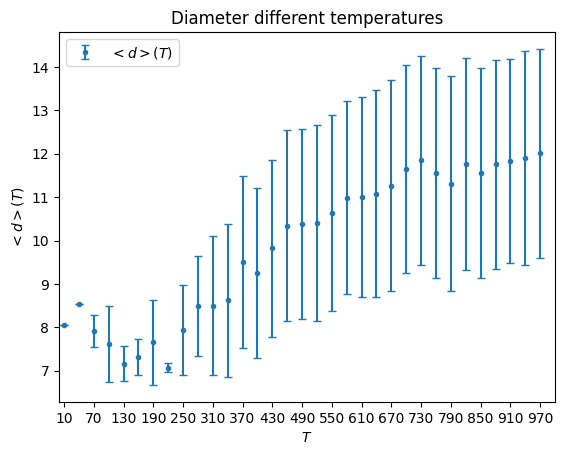

In [86]:

# Plotting the diameter for different temperatures.
fig, ax = plt.subplots()

ax.errorbar(
    T_interval,
    d_mean,
    yerr=d_std,
    fmt=".",
    capsize=3,
    label=r"$<d>(T)$"
)

ax.set(
    title="Diameter different temperatures",
    xlabel="$T$",
    ylabel="$<d>(T)$",
    xticks=T_interval[::2],
    xlim=(0,1000)
)
ax.legend()
plt.show()




Total runtime of all simulations: 
The diameter of the polymer is very similar to the energy of the polymer.
The diameter is large at high temperatures and sinks to around 250K before it doesn't follow any specific pattern anymore.
The standard deviation also becomes alot smaller at lower temperatures.

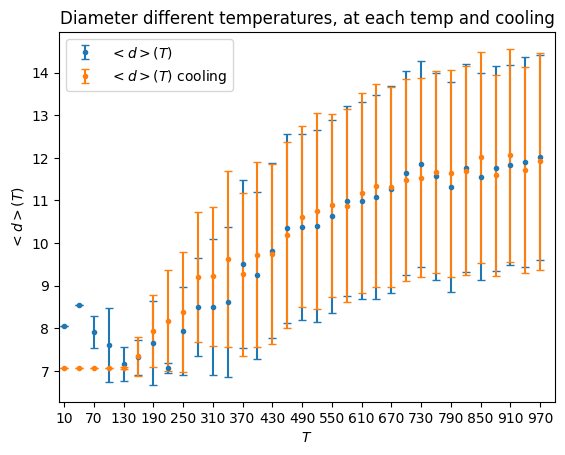

In [85]:
# Plotting cooling and different temperatures in the same plot 
fig, ax = plt.subplots()
ax.errorbar(
    T_interval,
    d_mean,
    yerr=d_std,
    fmt=".",
    capsize=3,
    label=r"$<d>(T)$"
)
ax.errorbar(
    T_interval,
    d_rep_mean,
    yerr=d_rep_std,
    fmt=".",
    capsize=3,
    label="$<d>(T)$ cooling"
)
ax.set(
    title="Diameter different temperatures, at each temp and cooling",
    xlabel="$T$",
    ylabel="$<d>(T)$",
    xticks=T_interval[::2],
    xlim=(0,1000)
)
ax.legend()
plt.show()

This process best describes cooling down a polymer.
The polymer that is cooled is more stable at lower temperatures and ends up being completetly stable for the lowest temperatures.
To see the behavior of the polymer at high and low temperatures, the process of cooling would be best. A polymer does not exist as flat in nature.
So a polymer when cooled would keep the stable shape from the higher temperature. 
At high temperatures the polymer will be very unstable, and both methods should be rather adequate. 

---

TODO:

- **Define the diameter $d$**
- **gjøre alle TODOs**
- **dobbeltsjekke (og trippeltsjekke) at funksjonene som ligger i notebooken er riktige.**
- **sjekke språk og kommentarer i koden**
- **sjekke språk i teksten**
- **hand in this notebook lol**